In [1]:
# %pip install numpy
# %pip install pandas
# %pip install matplotlib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import csv
import json
import dynamicsFunctions as dynF

Input Constants from .csv

NOTE: NEED TO ADD A CONSTANT TO CHOOSE EMRAX OR AMK MOTORS (AND THEN IT ONLY NEEDS TO READ THAT DATA - AND IT WILL ONLY ANALYZE CERTAIN DRIVETRAIN SECTIONS AS APPLICABLE - since the emrax data is less thorough...)

In [2]:
# USER-INPUT CONSTANTS
# STRING CONSTANTS
string_constants = 3
TRACK = None
regen_on = None                 # True/False - Regen on or off

# TRACK CONSTANTS
numLaps = None

# CAR CONSTANTS
no_cells_car_mass = None                     # kg - CAR MASS
Af = None                       # m^2 - FRONTAL AREA
Al= None                       # m^2 - WING ELEMENT AREA FROM TOP DOWN
mu_rr = None                    # COEFFICIENT OF ROLLING RESISTANCE

# BATTERY CONSTANTS
# DEPENDS ON STARTING CONDITIONS
initial_SoC = None              # % - INITIAL STATE OF CHARGE
starting_voltage = None         # V - INITIAL PACK VOLTAGE
capacity0 = None                # Ah - INITIAL PACK CAPACITY
# DEPENDS ON BATTERY CHOICE
max_capacity = None             # Ah
n_converter = None              # converter efficiency
cell_max_voltage = None         # V - MAX CELL VOLTAGE
cell_min_voltage = None         # V - MIN CELL VOLTAGE
cell_nominal_voltage = None
num_series_cells = None         # NUMBER OF SERIES ELEMENTS
num_parallel_cells = None       # NUMBER OF PARALLEL CELLS
single_cell_ir = None           # Ohms - CELL INTERNAL RESISTANCE
max_CRate = None                # Max C-Rate
cell_mass = None                # Mass of single cell
battery_cv = None               # Specific heat capacity of battery
# !!!
cell_water_area = None          # m^2 - WATER COOLING SURFACE OF CELL
cell_aux_factor = None          # kg/kWh - SEGMENT AUXILLARY MASS/ENERGY

# MOTOR CONSTANTS
motor_choice = None              # emrax / AMK - choose your motor

# TRACTION CONSTANTS
traction_speed = None           # km/h - MAX SPEED AROUND RADIUS IN TRACTION TEST
traction_radius = None          # m - RADIUS OF TRACTION TEST
mu_longitudinal = None          # Coefficient of longitudinal friction
mu_lateral = None               # Coefficient of lateral friction
brake_decel = None              # m/s^2 - BRAKING DECELERATION RATE
Cl = None                       # Lift coefficient
Cd = None                       # Draf coefficient

# !!! 
# THERMAL CONSTANTS
heatsink_air_area = None        # m^2 - AIR COOLING SURFACE OF CELL
heatsink_mass = None            # kg - TOTAL PACK HEATSINK MASS
heatsink_cv = None              # J/C*kg - HEATSINK MATERIAL SPECIFIC HEAT
air_temp = None                 # C - CONSTANT ASSUMED AIR TEMP
water_temp = None               # C - CONSTANT ASSUMED WATER TEMP
air_htc = None                  # W/C*m^2 - ASSUMED CONSTANT AIR HTC
water_htc = None                # W/C*m^2 - ASSUMED CONSTANT WATER HTC
thermal_resistance_SE = None    # K/W - ASSUMED SERIES ELEMENT THERMAL RESISTANCE
air_factor_m = None             # kg/kg AIR COOLING MASS PER BATTERY MASS
water_factor_m = None           # kg/kg WATER COOLING MASS PER BATTERY MASS

######################################################################
# This allows an external user to have control over the constants without touching the code

# Open .csv and take constants as input:
filename = "LapSimConstants.csv"

# Open the file
with open(filename, 'r', newline='') as infile:
    reader = csv.reader(infile)
    dataList = list(reader)
    dataList.pop(0)             # Remove title row

    # convert to array
    dataArray = np.array(dataList)

    # Take out the valuable columns and convert to floats as necessary
    value_name = dataArray[2:,0]
    value = dataArray[2:,2]
    value = np.asarray(value, dtype = float)

    track_name = dataArray[0,0]
    track = dataArray[0,2]

    regen_name = dataArray[1,0]
    regen = dataArray[1,2]

# Now create variables for everything
for x, y in zip(value_name, value):
    globals()[x] = y

globals()[track_name] = track
globals()[regen_name] = regen

###################################################################################
# CALCULATED CONSTANTS

# CONSTANTS - SHOULD NOT NEED CHANGING
delta_d = 0.01           # distance interval - m
g = 9.81                # m/s^2
# Motor
motor_choice = "AMK"
if motor_choice == 'AMK':
    GR = 14.33              # Gear Ratio - AMK
else:
    GR = 4.2                # Gear Ratio - emrax
wheel_diameter = 18 * 0.0254    # m
wheel_radius = wheel_diameter / 2
rho_air = 1.204         # air density: kg / m^3
v_air = 0               # air velocity: m/s
radsToRpm = 1 / (2 * math.pi) * 60    # rad/s --> rpm
max_power = 80000       # W

# Battery Pack - Calculated Values
num_cells = num_series_cells * num_parallel_cells
pack_nominal_voltage = cell_nominal_voltage * num_series_cells # V
pack_max_voltage = cell_max_voltage * num_series_cells # V
total_pack_ir = single_cell_ir / num_parallel_cells * num_series_cells  # ohms
# !!! Total known energy is approximately SoC * nominal voltage * max capacity
knownTotalEnergy = initial_SoC * capacity0 * pack_nominal_voltage / 1000  # kWh
pack_min_voltage = cell_min_voltage * num_series_cells  # V

# !!!
# Car Mass - Calculated Values
total_cell_mass = cell_mass*num_cells # kg
cooled_cell_mass = total_cell_mass*(1 + air_factor_m + water_factor_m) # kg
cell_aux_mass = cell_aux_factor*(capacity0 * pack_nominal_voltage / 1000) # kg
mass = no_cells_car_mass + cooled_cell_mass + cell_aux_mass + heatsink_mass # kg

# !!! 
# Thermals - Calculated Values
battery_heat_capacity = battery_cv*cell_mass # J/C
air_tc = air_htc*heatsink_air_area  # W/C
water_tc = water_htc*cell_water_area # W/C
air_thermal_resistance = 1 / air_tc  # K/W
heatsink_temp_0 = air_temp           # C
batteryTemp0 = air_temp             # C - starting temperature of battery pack (may change if necessary)

# Traction Constants
# at 30 km/h, we travelled around a 5 m radius circle
a_centrip = (traction_speed * 1000 / 3600)**2 / traction_radius      # v^2 / r (convert to m/s)
test_mass = 225                             # kg - car mass used in testing
F_friction = test_mass * a_centrip          # calculate the friction force
mu_lateral = F_friction / (test_mass * g)         # calculate the tire friction coefficient

# Some more arbitrary speed measurements
max_traction_force = mass * g * mu_longitudinal   # N - max force in LONGITUDINAL DIRECTION
F_friction = mu_lateral * mass * g                # friction force based on the evaluated car mass.

Import Datasets
1) AMK Motor
2) Emrax Motor
3) Track Data

In [3]:
####################
if motor_choice == "AMK":
    # AMK Motor
    # Import AMK Data
    in_json = 'AMK_data.json'
    in_json = open(in_json)
    in_json = in_json.read()
    AMK_dict = json.loads(in_json)

    # Converting list/dict storage into Dataframe and Array Storage
    ShaftTorque = pd.DataFrame(AMK_dict['ShaftTorque'])
    PowerFactor = pd.DataFrame(AMK_dict['PowerFactor'])
    TotalLosses = pd.DataFrame(AMK_dict['TotalLosses'])
    PeakTorqueSpeed = pd.DataFrame(AMK_dict['PeakTorqueSpeed']) # Just torque/speed
    ContTorqueSpeed = pd.DataFrame(AMK_dict['ContTorqueSpeed']) # Just torque/speed

    AMK_current = list(ShaftTorque.columns)
    AMK_current = np.array(AMK_current, dtype='float')
    AMK_speeds = list(ShaftTorque.index)
    AMK_speeds = np.array(AMK_speeds, dtype='float')

    print('AMK Chosen')

####################
else:
    # Emrax Motor
    # Convert .json to dictionary
    in_json = 'emrax_data.json'
    in_json = open(in_json)
    in_json = in_json.read()
    emrax_dict = json.loads(in_json)

    # Converting list/dict storage into Dataframe and Array storage
    MotorEfficiency = pd.DataFrame(emrax_dict['Motor Efficiency'])
    PeakTorqueSpeed = np.array(emrax_dict['PeakTorqueSpeed'])
    ContTorqueSpeed = np.array(emrax_dict['ContTorqueSpeed'])

    # Additional emrax data - also need a function handle for the Torque/Current Characteristic
    phases = 3
    pole_pairs = 10
    pm = emrax_dict['lambda_pm']

    # Function handle for managing torque --> Current changes (if necessary)
    torque_current = lambda I: phases / 2 * pole_pairs * pm * I

    print('Emrax chosen')

####################
# Track Data
infile = "Sim_Autocross.csv"
trackData = pd.read_csv(infile)

AMK Chosen


Pre-iteration analysis:
1) Track maximum velocities
2) Braking iteration

In [4]:
###################
# Track maximum velocities

b_vec = (trackData['Radius'] == 0) * 100000       # Create boolean vector for input data - and update the radius to be VERY large on straights
trackData['Radius'] = trackData.loc[:,'Radius'] + b_vec   # Then we update the radius vector

# And now... add a column to the dataframe with the maximum speed in each section (this is kinda like doing vector operations in MATLAB)
trackData = trackData.assign(MaxVelocity = np.sqrt(a_centrip * trackData['Radius']))    # Could make this more accurate by basing it off of down force at a specific time and speed, but idk...

# Vector length:
num_intervals = int(trackData.loc[trackData.index[-1], 'Cumulative Length'] / delta_d)

###################
# Braking Iteration

# Initialize a dictionary to store all of the braking informtion
TrackLength = int(trackData.shape[0]) # Provides the length of a column of the df

# sectors = list(np.linspace(0, TrackLength, num = TrackLength, endpoint=False)) # keys for the number of sectors

# brakeDict = dict.fromkeys(sectors, None)

brakeDict = dict.fromkeys(['Distance', 'Speed'], None)

# Dataframe parameters:
dictList = ['Time','Speed','Distance']

# Iterate through the track loop to determine the braking data at each point
for i in range(0, TrackLength):
    # Find sector length
    sectorLength = trackData.loc[trackData.index[i], 'Section Length']

    # Find sector vector length
    vectorLength = int(sectorLength / delta_d)

    # Initialize brakeSector_dict
    brakeSector_dict = dict.fromkeys(dictList)
    
    # add empty zero vectors...
    for k in range(0, len(dictList)):
        brakeSector_dict[dictList[k]] = np.zeros(vectorLength)

    # Initialize values in dict
    brakeSector_dict['Time'][vectorLength-1] = 0
    brakeSector_dict['Distance'][vectorLength-1] = trackData.loc[trackData.index[i], "Cumulative Length"]

    # Initialize the Max Velocity (Taking into account edge cases)
    if i != (TrackLength - 1):
        brakeSector_dict['Speed'][vectorLength - 1] = trackData.loc[trackData.index[i+1], 'MaxVelocity']
    else:
        brakeSector_dict['Speed'][vectorLength - 1] = trackData.loc[trackData.index[0], 'MaxVelocity']

    # Fill up the distance, time, and velocity from the back of the dataframe
    for j in range(0, vectorLength-1):
        # Iteration for distance, time, and velocity
        # First: solve for delta time:
        poly_coeffs = np.array([1/2, brakeSector_dict['Speed'][vectorLength - j - 1], -delta_d])          # coefficients: p[0] * x^n + ... + p[n]
        dt = np.roots(poly_coeffs)[1]                            # This is the delta_t
        brakeSector_dict['Time'][vectorLength - j - 2] = brakeSector_dict['Time'][vectorLength - j - 1] + dt

        # then for v1
        brakeSector_dict['Speed'][vectorLength - j - 2] = brakeSector_dict['Speed'][vectorLength - j - 1] + brake_decel * dt

        # Then for distance
        brakeSector_dict['Distance'][vectorLength - j - 2] = brakeSector_dict['Distance'][vectorLength - j - 1] - delta_d

    # FINALLY: save the dataframe into the brakeDict
    brakeDict['Speed'] = np.append(brakeDict['Speed'], brakeSector_dict['Speed'])
    brakeDict['Distance'] = np.append(brakeDict['Distance'], brakeSector_dict['Distance'])
    # brakeDict[sectors[i]] = brakeSector_dict

# Drop first row
brakeDict['Distance'] = np.delete(brakeDict['Distance'], 0)
brakeDict['Speed'] = np.delete(brakeDict['Speed'], 0)

At each sector, we want to do this:
* Determine the sector length
* Based on the delta_distance interval, determine the number of entries required
* Pre-allocate the data frame of the determine length with "None"
* The dataframe should have columns: distance, time, and velocity

* No - just fill up all the distance, time, and velocity arrays backwards - that'll be the easiest way to go about this.

* Now check for updates


Energy Used (This Sim):  9.5546723051491 kWh
Max Power (This Sim):  55.15472692666666 kW
Avg Power (This Sim):  24.363835193913243 kW
Car Mass: 230.54342400000002 kg
Lap Time:  69.12194714917412 s
Total Time:  25.344713954697177 mins
Completed


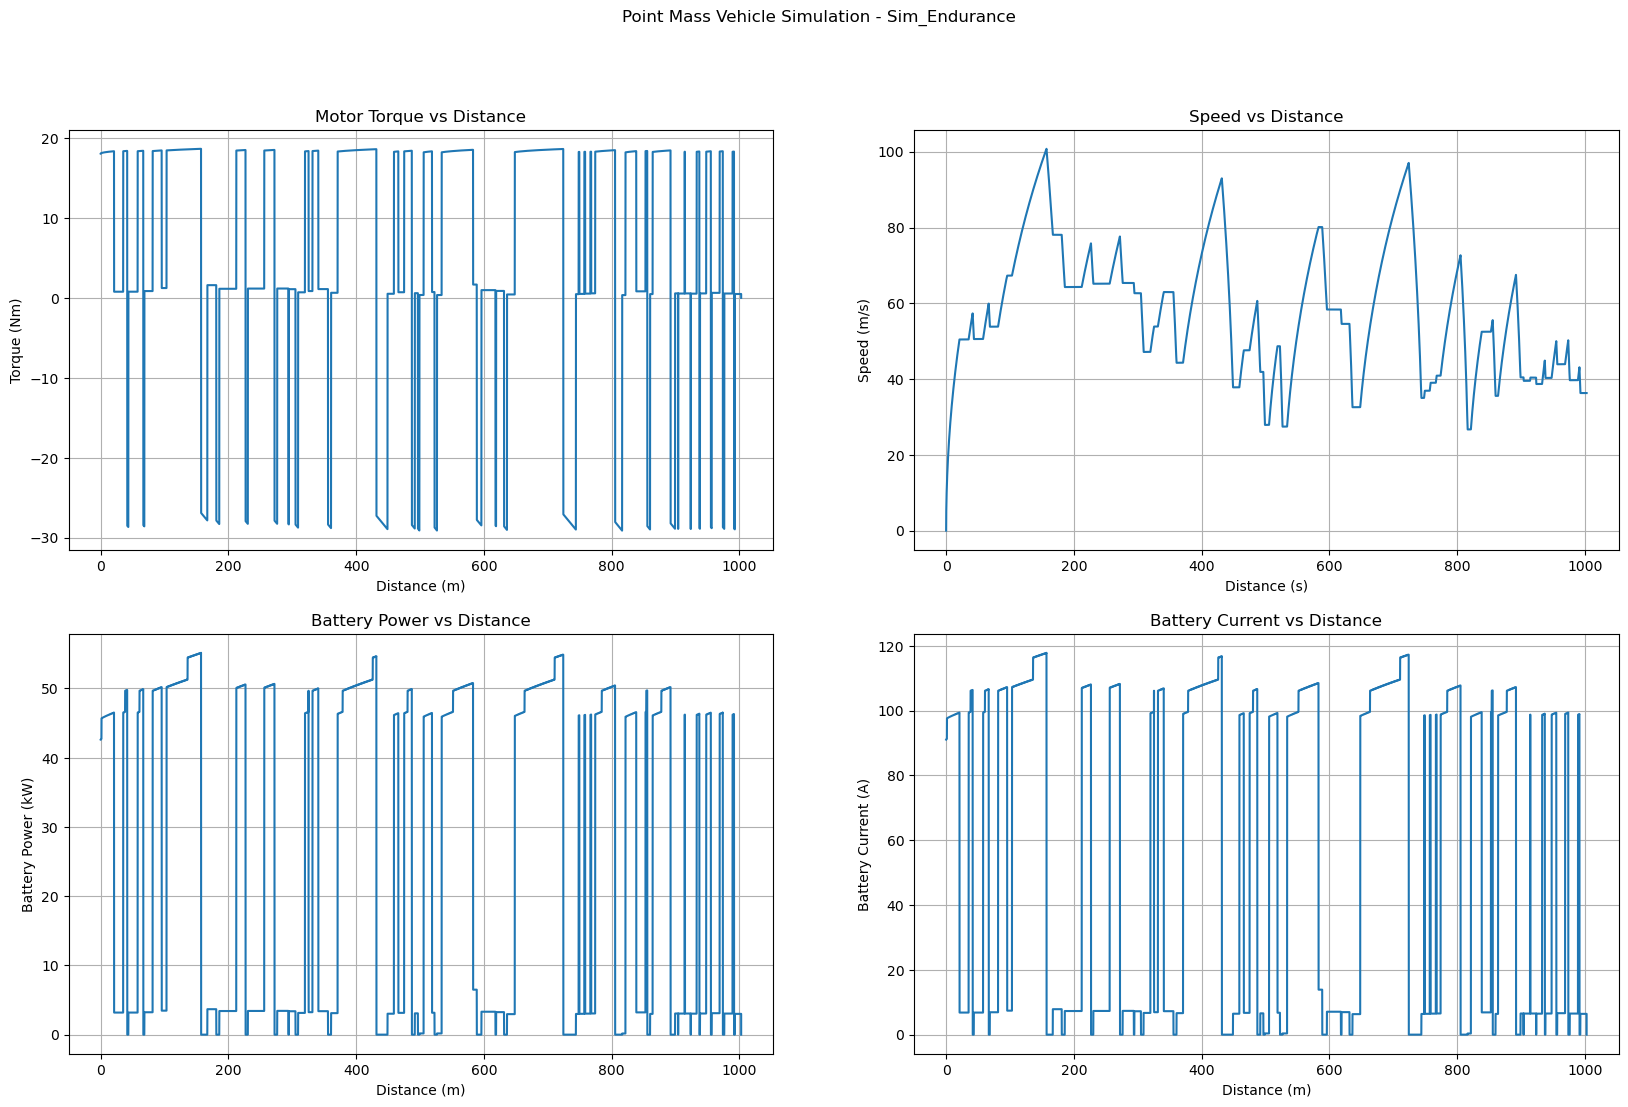

In [5]:
# Begin the iteration:

# Vectors for each set of data
# Create a dictionary of values
headers = ['v0',                    # velocity vector (m/s)
           'r0',                    # distance vector (m)
           't0',                    # time vector (s)
           'w_wh',                  # wheel angular velocity (rad/s)
           "w_m",                   # motor angular velocity (rpm)
           "T_m",                   # motor torque (Nm)
           "T_a",                   # Axel torque (Nm)
           "F_trac",                # traction force (N)
           "F_drag",                # drag force (N)
           "F_down",                # down force (N)
           "F_RR",                  # rolling resistance (N)
           "F_net_tan",             # net force in the tangential direction (N)
           "a_tan0",                # tangential acceleration (m/s^2)
           "a_norm0",               # normal/centripetal acceleration (m/s^2)
           "P_battery",             # battery power (kW)
           "V_battery",             # battery voltage (V)
           "P_battery_regen",       # battery regen power (kW)
           "Capacity",              # Battery capacity (Ah)
           "Pack Current",          # Battery pack current (A)
           "Energy Use",            # energy use over time (kWh)
           "SoC Energy",            # state of charge - energy based (%)
           "SoC Capacity",          # state of charge - capacity based (%)
           "Dissipated Power",      # Power dissipated from batteries due to internal resistance (W)
           "Battery Temp",          # Temperature of battery pack (C)
           "Heatsink Temp",         # Temperature of the heat sink (C)
           "Max Values"]            # maximum battery power used, total energy used
dataDict = dict.fromkeys(headers)

# add empty zero vectors
for i in range(0, len(headers)):
    dataDict[headers[i]] = np.zeros(num_intervals)

# Add some starting values
dataDict['Capacity'][0] = capacity0
dataDict['SoC Capacity'][0] = initial_SoC
dataDict['Battery Temp'][0] = batteryTemp0
dataDict['Heatsink Temp'][0] = heatsink_temp_0
dataDict['V_battery'][0] = pack_max_voltage

# CALCULATIONS
for i in range(0, num_intervals-1):
    # INITIAL CALCULATIONS

    # Calculates the fastest next speed and the smallest possible time
    dataDict = dynF.fastestNextSpeed(dataDict, PeakTorqueSpeed, i)

    #########################################  
    # TRACTION CALCULTIONS

    # # Determine track location and current radius:
    # trackLocation = np.searchsorted(trackLength, dataDict['r0'][i])    # index of track location

    # # break out of loop once we hit the end of the track
    # if trackLocation > len(trackRadius) - 1:              
    #     break
   
    # # determine instantaneous track radius
    # current_radius = trackRadius[trackLocation]

    # Now, check to find the maximum actually possible speed based on traction considerations
    v_max = dynF.findMaxSpeed(trackData, dataDict, i)

    # Now determine whether we exceed the maximum speed in a, and if so, recalculate the possible values
    if dataDict['v0'][i+1] > v_max:
        # print('Above max speed - iteration %d' % i)
        dataDict = dynF.limit_max_speed(dataDict, v_max, i)

    # Add the braking
    dataDict = dynF.braking(brakeDict, dataDict, i)

    ###########################################

    # Determine battery power used during the race
    dataDict = dynF.batteryPower(dataDict, i, ShaftTorque, PowerFactor, TotalLosses, AMK_current, AMK_speeds)

    # Add safety checks on the battery here
    dataDict = dynF.batteryChecks(dataDict, i, AMK_current, AMK_speeds, ShaftTorque)

    # Additional Battery Calculations
    dataDict = dynF.extraBatteryCalcs(dataDict, i)

    # Energy calculations
    dataDict = dynF.energyConsumed(dataDict, i)

# # !!! TO FIX
# # Trapezoidal approximation for energy used
# energy, totalEnergy = dynF.trapezoidApprox(dataDict['P_battery'])
# dataDict['Energy Use'] = energy

# # Determine SoCe based on this!
# dataDict = dynF.SoCenergy(dataDict, knownTotalEnergy)

# Energy use to display
total_energy = dataDict['Energy Use'][-1] * numLaps
dataDict['Max Values'][1] = total_energy
print('Energy Used (This Sim): ', total_energy, 'kWh')

# Determination of maximum power
dataDict['P_battery'] = dataDict['P_battery'] / 1000        # convert to kW
maxPower = max(dataDict['P_battery'])
averagePower = np.mean(dataDict['P_battery'])

# dataDict['Max Values'][2] = "Max power Used (kW)" - cannot put this in bc it's a string
dataDict['Max Values'][3] = maxPower
print("Max Power (This Sim): ", maxPower, "kW")
print("Avg Power (This Sim): ", averagePower, "kW")
print("Car Mass: " + str(mass) + " kg")

# Additional Outputs
dataDict['v0'] = dataDict['v0'] * 3.6            # convert to km/h
print("Lap Time: ", dataDict['t0'][-1], "s")
print("Total Time: ", dataDict['t0'][-1] * numLaps / 60, "mins")
# print("Final SoC(c): ", dataDict['SoC Capacity'][-1], "%")

# Now I want to write all the columns to a dictionary and then input it into a dataframe - since it's easier to do column-wise
dfData = pd.DataFrame(dataDict)
dfData.dropna(inplace = True)

# Output to csv
outfile = "dynamicsCalcs.csv"
dfData.to_csv(outfile, index=False)

# Create plots
dynF.plotData(dataDict)
print("Completed")

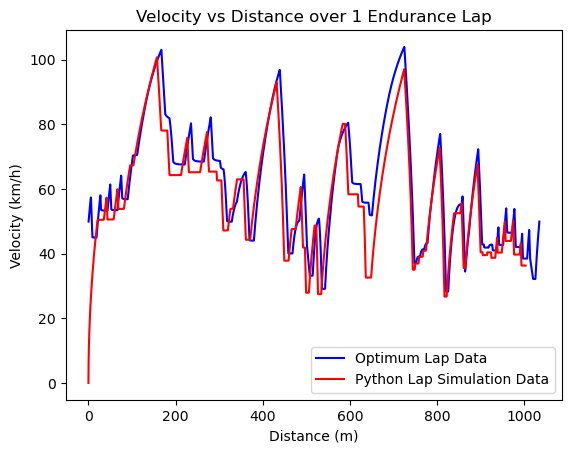

In [6]:
# Optimum Lap Comparison
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Constants
OPTIMUMLAP = "OptimumLapSim61.40.csv"

# Analyze current data
time = dataDict['t0']
velocity = dataDict['v0']
distance = dataDict['r0']

# Import actual csv
infile = OPTIMUMLAP
dfO = pd.read_csv(infile, header = [0])
dfO = dfO.drop(index = 0)
distanceO = dfO.loc[:,'elapsedDistance'].to_numpy(dtype = float)
timeO = dfO.loc[:,'elapsedTime'].to_numpy(dtype = float)
velocityO = dfO.loc[:,'speed'].to_numpy(dtype = float)

# plot the graphs on top of each other
plt.plot(distanceO, velocityO, 'b')
plt.plot(distance, velocity, 'r')
plt.xlabel('Distance (m)')
plt.ylabel('Velocity (km/h)')
plt.title('Velocity vs Distance over 1 Endurance Lap')
plt.legend(['Optimum Lap Data', 'Python Lap Simulation Data'])
plt.show()